<img src="images/scilife_logo.png" width="400">
<img src="images/essence_logo.png" width="300">

# SciLifeLab Workshop - Hands-on Section: LangGraph "Hello World"



Welcome to this hands‑on lab session on building AI agents with **LangGraph**! LangGraph is a low‑level orchestration framework for constructing stateful AI workflows using graphs, where nodes represent units of work and edges define how those units are connected. LangGraph provides several key benefits for agentic AI applications, including durable execution, support for human‑in‑the‑loop workflows, comprehensive memory (both short‑ and long‑term), built‑in debugging, and production‑ready deployment features.

## Learning Objectives
By the end of this workshop you will:
- Understand core concepts of LangGraph (tools, nodes, edges, state, and memory).
- Create and integrate your own tools for an AI agent.
- Build a ReAct‑style agent from scratch using an LLM and custom tools.
- Implement agent memory to maintain conversational context.
- Compare custom agents with prebuilt LangGraph agents.
- Explore extension tasks such as error handling, streaming, and domain‑specific tools.

## Workshop Timeline (60 minutes)
- **Part 1 (10 min)**: Setup & imports
- **Part 2 (20 min)**: Understanding and creating tools
- **Part 3 (10 min)**: Defining the state
- **Part 4 (15 min)**: Building the agent graph
- **Part 5 (5 min)**: Testing the agent
- **Part 6 (10 min)**: Adding short‑term memory
- **Part 7 (10 min)**: Exploring prebuilt agents
- **Part 8 (optional)**: Extension exercises


---

## Part 1 – Setup

In this first step, we'll import the necessary dependencies and load any environment variables. Make sure your API keys (e.g. OpenAI) are stored in a `.env` file in the same directory.

**Note: This part will be modified later if we used local model rather than OpenAI or Claude**

### Exercise 1.1 – Import dependencies (participant cell)

Import the standard libraries and load environment variables:

- Import json
- Use `load_dotenv()` from the `dotenv` package to load variables from your `.env` file.

In [10]:
# Import any packages you need here
import json
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

True

---

## Part 2 – Understanding and Creating Tools

In LangGraph, **tools** are Python functions that extend your agent's capabilities beyond text generation. They can call external APIs or perform computations, and are annotated with the `@tool` decorator from LangChain. A tool takes typed inputs and returns a string; the LLM can decide when to call a tool as part of the conversation.

When design tools for agent, there are 3 important considerations: 
- **Input - Output**: It is similar to when design python function, but the input now is handle by generated content from LLM. Output should be parsed to feed meaningful context for agent context 

- **Description**: the `@tool` decorator require docstrings from python function and will use it as tools description. These description will feed the LLM system prompts, make it to understand when to call which tools. 

### Tool Creation API Reference

```python
from langchain.tools import tool

@tool
def your_function_name(parameter: type) -> str:
    """Clear description of what this tool does.

    Args:
        parameter: Description of the parameter

    Returns:
        Information to pass back to the agent.
    """
    # implementation here
```


### About the task

In this exercise, we will establish 3 tools that are useful for drug discovery domain.

**1. Calculator:** a tool to execute mathematical expression

**2. LitSearch:** a tool to perform semantic search on all publication available on PubMed

**3. GetDrugInfo:** a tool to retrieve drugs information given drug name

### Exercise 2.1 – Create a Calculator Tool

Write a tool that evaluates simple arithmetic expressions (e.g. `'2 + 3 * 4'`). Use Python's built‑in `eval` to perform the calculation, and wrap your function with the `@tool` decorator. Your tool should accept a string input called `expression` and return a string result.

In [11]:
from langchain.tools import tool

@tool
def calculator(expression: str) -> str:
    """Evaluate a simple arithmetic expression (e.g. '2 + 3 * 4')."""
    try:
        result = eval(expression)
        return str(result)
    except Exception as exc:
        return f"Error evaluating expression: {exc}"

### Exercise 2.2 – Create a Literature Search Tool

Use the **LitSense** API to perform semantic search of PubMed articles. Your tool should accept a `query` string and an optional `limit` integer. Below is the API reference of LitSense Wrapper. Have a look at it to have implementation idea. 

### **LitSense API Reference**

```python
from litsense_wrapper import LitSense_API

query = 'COVID-19 biological targers'
engine = LitSense_API()
results = engine.retrieve(query, limit=5) # return a list of LitSense object with attributes, such as text, pmid, etc.
```

### **References**
LitSense: https://academic.oup.com/nar/article/53/W1/W361/8133630

Github: https://github.com/DinhLongHuynh/LitSense_Wrapper

In [12]:
from langchain.tools import tool
from litsense_wrapper import LitSense_API

@tool
def lit_search(query: str, limit: int = 5) -> str:
    """Retrieve information from PubMed using a semantic search via the LitSense API.\n\n
    Args:
        query: The research question or topic to search for in PubMed literature.
        limit: Maximum number of results to return (default is 5).
    Returns:
        A formatted string containing semantically relevant passages from PubMed articles, including PMID and content only.
    """

    try:
        engine = LitSense_API()
        results = engine.retrieve(query, limit=limit)
        if not results:
            return f"No relevant literature found for '{query}'. Please try a different or broader search query."
        result_str = ""
        for i, result in enumerate(results):
            result_str += (
                f"\n--- Passage #{i+1} ---\n"
                f"PMID: {result.pmid}\n"
                f"Content: {result.text}\n"
            )
        return result_str
    except Exception as e:
        return f"Error retrieving literature for '{query}': {str(e)}. Please try a different search query."

### Exercise 2.3 – Create a Drug Information Tool

Build a tool that queries the **ChEMBL** database for comprehensive drug information. Use the `chembl_webresource_client` to search for molecules by name or synonym. If you find multiple candidates, select the first one. Return a formatted string containing the molecule's name, mechanism of action, and therapeutic indications.

In [13]:
from chembl_webresource_client.new_client import new_client

@tool
def get_drug_info(drug_name: str) -> str:
    """Return comprehensive drug information using the ChEMBL database (supports synonyms)."""
    try:
        # Search for the molecule using synonyms/trade names
        search_results = new_client.molecule.search(drug_name)
        search_list = list(search_results)
        if not search_list:
            return f"No information found for '{drug_name}'"

        candidate = search_list[0]
        chembl_id = candidate['molecule_chembl_id']
        details = new_client.molecule.get(chembl_id)

        # Build base result
        pref_name = details.get('pref_name') or candidate.get('pref_name') or drug_name
        result = f"**{pref_name}** (ChEMBL ID: {chembl_id})\n"
        result += f"Type: {details.get('molecule_type', 'Not specified')}\n"

        # Include molecular formula if available
        if details.get('molecule_properties', {}).get('molecular_formula'):
            result += f"Molecular Formula: {details['molecule_properties']['molecular_formula']}\n"

        # Include synonyms/trade names if available
        synonyms = details.get('molecule_synonyms', []) or []
        if synonyms:
            result += "\n**Synonyms/Trade names:**\n"
            unique_synonyms = set()
            for syn in synonyms[:15]:
                name = syn.get('molecule_synonym') or syn.get('synonyms')
                if name and name.lower() != pref_name.lower():
                    unique_synonyms.add(name)
            for name in sorted(unique_synonyms):
                result += f"- {name}\n"

        # Mechanism of action
        try:
            mechanisms = new_client.mechanism.filter(
                molecule_chembl_id=chembl_id
            ).only(['mechanism_of_action', 'target_chembl_id'])
            mechanism_list = list(mechanisms)
            if mechanism_list:
                result += "\n**Mechanism of Action:**\n"
                unique_mechanisms = set()
                for mech in mechanism_list[:5]:
                    moa = mech.get('mechanism_of_action')
                    if moa:
                        unique_mechanisms.add(moa)
                for moa in sorted(unique_mechanisms):
                    result += f"- {moa}\n"
        except Exception as e:
            result += f"\nMechanism of action data not available (Error: {str(e)[:50]}...)\n"

        # Indications
        try:
            indications = new_client.drug_indication.filter(
                molecule_chembl_id=chembl_id
            ).only(['efo_term', 'mesh_heading', 'max_phase_for_ind'])
            indication_list = list(indications)
            if indication_list:
                result += "\n**Indications:**\n"
                unique_indications = set()
                for ind in indication_list[:10]:
                    indication_name = ind.get('efo_term') or ind.get('mesh_heading')
                    max_phase = ind.get('max_phase_for_ind')
                    if indication_name:
                        phase_info = f" (Phase {max_phase})" if max_phase else ""
                        unique_indications.add(f"{indication_name}{phase_info}")
                for indication in sorted(unique_indications):
                    result += f"- {indication}\n"
            else:
                result += "\nNo indication data available.\n"
        except Exception as e:
            result += f"\nIndication data not available (Error: {str(e)[:50]}...)\n"

        # Bioactivity summary
        try:
            activities = new_client.activity.filter(
                molecule_chembl_id=chembl_id
            ).only(['standard_type', 'standard_value', 'standard_units'])
            activity_list = list(activities)
            if activity_list:
                result += f"\n**Bioactivity Data Available:** {len(activity_list)} records\n"
                activity_types = {}
                for act in activity_list[:100]:
                    act_type = act.get('standard_type')
                    if act_type:
                        activity_types[act_type] = activity_types.get(act_type, 0) + 1
                if activity_types:
                    top_types = sorted(activity_types.items(), key=lambda x: x[1], reverse=True)[:5]
                    result += "Most common activity types: " + \
                        ", ".join([f"{t[0]} ({t[1]})" for t in top_types]) + "\n"
        except Exception:
            pass  # Bioactivity optional

        return result

    except Exception as e:
        return f"Error querying ChEMBL database for '{drug_name}': {str(e)}"


### Exercise 2.4 – Create a Tools List

Collect all of your tool functions into a single list called `TOOLS`. This list will be passed to the LLM so that it knows what tools are available.

In [14]:
TOOLS = [calculator, lit_search, get_drug_info]

---

## Part 3 – Understanding LangGraph State

A LangGraph **state** defines the data that flows through your agent. For chat agents, the state typically contains a list of messages which grows over the conversation. When creating a state schema, you use `TypedDict` to describe the keys and `Annotated` with reducer functions to specify how values should be updated. The `add_messages` reducer appends new messages rather than overwriting them.


### Exercise 3.1 – Define Chat State

Define a `ChatState` class (subclassing `TypedDict`) with a single key `messages`. Use the `add_messages` reducer so that new messages are appended to the state.

In [15]:
from typing_extensions import TypedDict
from typing import Annotated, List, Dict
from langgraph.graph.message import add_messages

class ChatState(TypedDict):
    """The state schema for our LangGraph. It contains only a list of messages.

    Messages are appended via the `add_messages` reducer to preserve the full conversation history. 
    Each message is represented as a dict with `role` and `content` keys (compatible with the OpenAI API message format)."""
    messages: Annotated[List[Dict], add_messages]

---

## Part 4 – Building the Agent Graph

An agent graph describes how your agent processes messages. You will build a graph using **nodes** (functions) and **edges** (connections between functions). Nodes can be the chatbot itself or tool‑calling logic, and edges determine the execution flow.

### Exercise 4.1 – Initialize Components

1. Create a `StateGraph` instance using your `ChatState`.
2. Initialise a chat model with `ChatOpenAI(model='gpt-4o', temperature=0)`.
3. Bind your tools to the LLM using `bind_tools()`.
4. Create a `ToolNode` from your tools list.

In [16]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI

# Create graph builder using ChatState
graph_builder = StateGraph(ChatState)

# Initialise the chat model. Ensure your OpenAI API key is set in the .env file
llm = ChatOpenAI(model='gpt-4o', temperature=0)

# Bind the tools to the LLM so that it knows their schemas and how to construct tool calls in JSON
llm_with_tools = llm.bind_tools(TOOLS)

# Create a ToolNode using our tools list
tool_node = ToolNode(tools=TOOLS)

### Exercise 4.2 – Define the Chatbot Node

Define a chatbot function that takes the state as input and returns a dictionary with a single key `messages`, containing the LLM response.

In [17]:
from typing import Dict, List

def chatbot(state: ChatState) -> Dict[str, List]:
    """The main chatbot node. It invokes the LLM with the current messages."""
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

### Exercise 4.3 – Define the Routing Function

Create a function `route_tools` that decides whether to call tools or terminate. If the most recent AI message contains tool calls (`tool_calls` attribute), route to the `'tools'` node; otherwise return `END`.

In [18]:
def route_tools(state: ChatState) -> str:
    messages = state.get('messages', [])
    ai_message = messages[-1] if messages else None
    if ai_message and getattr(ai_message, 'tool_calls', []):
        return 'tools'
    return END

### Exercise 4.4 – Build the Complete Graph

Assemble the agent graph by adding nodes and edges, then compile the graph into a runnable agent. Use `add_node()` for your chatbot and tool nodes, `add_conditional_edges()` for routing logic, and `add_edge()` to connect nodes.

In [19]:
# Add the chatbot node to the graph
graph_builder.add_node('chatbot', chatbot)

# Add the tool node to the graph
graph_builder.add_node('tools', tool_node)

# Add conditional edges from chatbot using the routing function
graph_builder.add_conditional_edges('chatbot', route_tools, {'tools': 'tools', END: END})

# Add edge from tools back to chatbot
graph_builder.add_edge('tools', 'chatbot')

# Add edge from START to chatbot
graph_builder.add_edge(START, 'chatbot')

# Compile the graph into an agent
agent = graph_builder.compile()

### Exercise 4.5 – Visualize Your Agent

Use the graph's `draw_mermaid_png()` method to visualize the structure of your agent. This step is optional but helps you understand how nodes and edges connect.

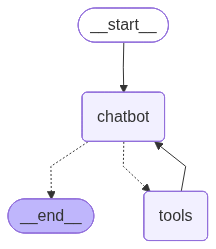

In [11]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    print('Graph visualization not available in this environment.')

---

## Part 5 – Testing Your Agent

Now that your agent graph is built, it's time to interact with it. Create a simple chat loop that greets the user, processes input until they type 'quit', and streams responses using `agent.stream()`.

### Exercise 5.1 – Create a Basic Chat Loop

Write an interactive loop that:
1. Greets the user and explains the agent's capabilities.
2. Reads user input in a loop and exits on `'quit'`, `'exit'` or `'q'`.
3. Creates the initial `state` with the user's message and streams the agent's responses via `agent.stream()`.
4. Uses the `pretty_print()` method on messages to display nicely formatted output.


Try out this chat loop with these three prompts: 

- **Prompt 1:** ” You are an expert drug discovery researcher. Use your available tools to answer the user’s question as accurately as possible. Never fabricate or invent data. What is the mechanism of action of remdesivir and what bioactivity data is available for this compound?”


- **Prompt 2:**  " You are an expert drug discovery researcher. Use your available tools to answer the user’s question as accurately as possible. Never fabricate or invent data. I'm investigating potential combination therapies for COVID-19. Can you help me understand the mechanisms of both hydroxychloroquine and azithromycin, then find recent literature discussing their combined use in COVID-19 treatment?”


- **Prompt 3:**  " You are an expert drug discovery researcher. Use your available tools to answer the user’s question as accurately as possible. Never fabricate or invent data. I'm working on Alzheimer's drug discovery and need to evaluate aducanumab. Please provide detailed drug information including its development status, then search for recent publications about its clinical trial outcomes and any controversies surrounding its approval."


In [ ]:
print('Welcome to the LangGraph ReAct demo! Ask me a question.')
print('I can perform simple math, look up drug information, and search PubMed via LitSense.')
print('====================================================================')

while True:
    try:
        user_input = input('User: ')
    except EOFError:
        break

    if not user_input or user_input.lower() in {'quit', 'exit', 'q'}:
        print('Goodbye!')
        break

    state = {
        'messages': [
            {'role': 'user', 'content': user_input}
        ]
    }

    for event in agent.stream(state):
        for value in event.values():
            # The last message in the state is the AI response
            msg = value["messages"][-1]
            # Use the built-in pretty_print method for better formatting
            msg.pretty_print()

---

## **Part 6: Adding Short‑term Memory**

To demonstrate the lack of memory in agent, please go back to Part 5, then perform these two prompts: 

- **Prompt 1:** My compound of interest is aspirin. Please remember this information.

- **Prompt 2:** What is my interested compound?

You will see when invoke **prompt 2**, the agent can not come up with the right answer - aspirin. It is because the GraphState is only maintained from START node to END node. After termination, every context from previous run is gone. Therefore, we need a component call Agent Memory to maintain context across runs.

Memory allows your agent to remember previous parts of the conversation. LangGraph uses "checkpointers" to maintain state across interactions.

### Exercise 6.1 – Add Memory to Your Agent

Rebuild your agent with memory by creating a new `StateGraph` that uses the same `ChatState`. Use an `InMemorySaver` to persist state across turns, and pass a configuration dictionary with a unique `thread_id` when streaming.

In [49]:
from langgraph.checkpoint.memory import InMemorySaver

class ChatState(TypedDict):
    messages: Annotated[List[Dict], add_messages]

graph_builder = StateGraph(ChatState)

llm = ChatOpenAI(model='gpt-4o', temperature=0)
llm_with_tools = llm.bind_tools(TOOLS)

def chatbot(state: ChatState) -> Dict[str, List]:
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

tool_node = ToolNode(tools=TOOLS)

graph_builder.add_node('chatbot', chatbot)
graph_builder.add_node('tools', tool_node)
graph_builder.add_conditional_edges('chatbot', route_tools, {'tools': 'tools', END: END})
graph_builder.add_edge('tools', 'chatbot')
graph_builder.add_edge(START, 'chatbot')

saver = InMemorySaver()
agent = graph_builder.compile(checkpointer=saver)

### Exercise 6.2 – Create a Memory‑Enabled Chat Loop

Write a chat loop similar to Part 5, but supply a `config` dictionary to `agent.stream()` containing a unique `thread_id` and `recursion_limit`. The same thread ID should be used for the entire conversation.

In [50]:
# Create config for memory
config = {
    'configurable': {
        'thread_id': 'example_conversation',
        'recursion_limit': 25
    }
}

In [ ]:
print('Welcome to the LangGraph ReAct demo with memory! Ask me a question.')
print('I can perform simple math, look up drug information, and search PubMed via LitSense.')
print('====================================================================')

while True:
    try:
        user_input = input('User: ')
    except EOFError:
        break

    if not user_input or user_input.lower() in {'quit', 'exit', 'q'}:
        print('Goodbye!')
        break

    state = {
        'messages': [
            {'role': 'user', 'content': user_input}
        ]
    }

    for event in agent.stream(state, config=config):
        for value in event.values():
            # The last message in the state is the AI response
            msg = value["messages"][-1]
            # Use the built-in pretty_print method for better formatting
            msg.pretty_print()

---

## Part 7 – Prebuilt Agents

LangGraph provides prebuilt agents that implement common architectures such as the ReAct pattern. These agents are quick to set up and let you focus on your tools and prompts rather than on graph wiring.

### Exercise 7.1 – Create a Prebuilt Agent

Use `create_react_agent` to instantiate a prebuilt ReAct agent. Provide your LLM, tools list, and a custom system prompt that instructs the agent how to behave.

In [ ]:
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model='gpt-4o', temperature=0)

agent = create_react_agent(
    model=llm,
    tools=TOOLS,
    prompt=(
        "You are an expert drug discovery researcher. Use your available tools to answer the user's question as accurately as possible. Never fabricate or invent data."
    )
)

---

## Part 8 – Extension Exercises

I need some ideas here

- System prompt (prompt template)
- Output parser
- Long-term memory


### Exercise 8.1 – Create a system prompt using a prompt template

In LangGraph, you can provide a **system** or **instruction** message that sets the behaviour of the assistant before any user input is processed. LangGraph exposes this functionality via its `prompts` module. There you will find a few classes: `PromptTemplate` for formatting a single string, `ChatPromptTemplate` for building multi-message prompts, and `MessagesPlaceholder` for inserting a slot where conversation history will later be filled.

In this exercise you will define a `ChatPromptTemplate` that begins with a system instruction. The system message should describe the assistant’s role (for example, instructing it to behave like a drug discovery researcher) and will be prepended to the user’s request before being passed to the agent.

#### Prompt Template API References: https://python.langchain.com/docs/concepts/prompt_templates/


In [51]:
from langchain_core.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert drug discovery researcher. Use your available tools to answer the user’s question as accurately as possible. Never fabricate or invent data."),
    ("user", "{request}")
])

prompt_values = prompt_template.invoke({"request": "What is the mechanism of action of remdesivir and what bioactivity data is available for this compound?"})

`prompt_values` is a dictionary, which can be invoke directly to the agent. Try out by simple invoke the agent with the `prompt_values`

In [ ]:
msgs = agent.invoke(prompt_values, config=config)
for msg in msgs['messages']:
    msg.pretty_print()

### Exercise 8.2 – Integrate the system prompt with a streaming loop

Building on the previous exercise, implement a multi-turn chat loop. Use a `while` loop to repeatedly accept user input, stream the agent’s response, and append both user and assistant messages to the conversation state.

To include your system instruction in every turn, apply the `ChatPromptTemplate` from exercise 8.1 when constructing the input for the agent. When using the streaming API you must supply a `state` dictionary that includes a `'messages'` key. The value of this key should be a list of message dictionaries (each with `role` and `content` fields) representing the conversation history. As you loop, update this list to maintain the context across turns.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate

config = {
    "configurable": {
        "thread_id": "example_conversation",
        "recursion_limit": 25,
    }
}


prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are an expert drug discovery researcher. Use your available tools to answer the user’s question as accurately as possible. Never fabricate or invent data."),
    ("human", "{request}"),
])

print("Welcome to the LangGraph ReAct demo with memory! Ask me a question.")
print("I can perform simple math, look up drug information, and search PubMed via LitSense.")
print("====================================================================")

while True:
    try:
        user_input = input("User: ")
    except EOFError:
        break

    if not user_input or user_input.lower() in {"quit", "exit", "q"}:
        print("Goodbye!")
        break

    # Build the state as a dict with a messages list
    prompt_value = prompt_template.invoke({"request": user_input})
    state = {"messages": prompt_value.messages}

    # Stream agent events
    for event in agent.stream(state, config=config):
        for value in event.values():
            msg = value["messages"][-1]
            msg.pretty_print()

## Exercise 9.1 - Structure Output Parser

Structured output parsers let you control the format of the language model’s responses. Instead of returning free‑form text, the model follows a schema (such as a Pydantic model) so that other components can reliably consume its output.

- **Why?** Downstream software often expects data in a specific JSON schema (e.g. key–value pairs).
- **How?** Define a Pydantic `BaseModel` to describe the fields you need, then use `with_structured_output(...)` to attach this schema to your LLM.

You can read more in the [LangGraph structured output guide](https://langchain-ai.github.io/langgraph/how-tos/react-agent-structured-output/#define-model-tools-and-graph-state).

The diagram below shows the high‑level structure of the system we’re about to build. One LLM is responsible for deciding when to call tools, and a second LLM is tasked with formatting the final response according to your schema.

<img src="images/react_structured_output.png" width="300">


First we'll set up two language models:

1. **Tool‑calling LLM**: This model can invoke the tools you defined earlier (calculator, literature search, etc.).
2. **Structured output LLM**: This model will use a Pydantic schema to return the final answer as JSON with fields for drug names, justifications and sources.

When we later ask a question such as *"Use LitSearch literatures, give me 2 antiviral drugs that are potential to treat COVID‑19"*, the agent will search PubMed via LitSense, find candidate antivirals, and then format its answer using this schema.


In [ ]:
# Step 1: create the tool-calling LLM
llm = ChatOpenAI(model='gpt-5', temperature=0)
llm_with_tools = llm.bind_tools(TOOLS)

# Step 2: define a Pydantic schema describing the structured output we want
from pydantic import BaseModel, Field

class DrugsInfo(BaseModel):
    drugs: str = Field(description='a list of drug names')
    justifications: str = Field(description='a list of justification for each drugs')
    sources: str = Field(description='a list of citation for each drugs')

# Step 3: create the structured output LLM
llm = ChatOpenAI(model='gpt-5', temperature=0)
llm_with_structured_outputs = llm.with_structured_output(DrugsInfo)


In [ ]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from typing import Dict, List
from langchain_core.messages import HumanMessage, AIMessage

# Define the chatbot node: this function invokes the tool‑calling LLM and appends the AI message to state
def chatbot(state: ChatState) -> Dict[str, List]:
    """The main chatbot node. It invokes the LLM with the current messages."""
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

# Define the respond node: this function uses the structured‑output LLM to format the final answer
def respond(state: ChatState):
    # Extract only the content of each message for the structured LLM
    response = llm_with_structured_outputs.invoke(
        [HumanMessage(content=state["messages"][i].content) for i in range(len(state["messages"]))]
    )
    # Wrap the structured JSON as an AIMessage and return it
    return {"messages": [AIMessage(content=response.model_dump_json())]}

# Define a simple routing function to decide whether to keep calling tools or format a final response
def should_continue(state: ChatState):
    messages = state["messages"]
    last_message = messages[-1]
    # If the last message does not contain a tool call, we are ready to format a response
    if not last_message.tool_calls:
        return "respond"
    # Otherwise, continue invoking tools
    else:
        return "continue"

# Build the state graph
workflow = StateGraph(ChatState)

# Add the nodes: chatbot (for reasoning/tool calls), respond (for final formatting), and the existing tool node
workflow.add_node("chatbot", chatbot)
workflow.add_node("respond", respond)
workflow.add_node("tools", tool_node)

# Set the entry point: we start by invoking the chatbot node
workflow.set_entry_point("chatbot")

# Add conditional edges: route to either tools or respond depending on should_continue
workflow.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

# After calling tools, loop back to the chatbot; after responding, end the workflow
workflow.add_edge("tools", "chatbot")
workflow.add_edge("respond", END)

# Compile the workflow into an executable agent
agent = workflow.compile()


In [ ]:
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    print('Graph visualization not available in this environment.')

In [ ]:
# Ask the agent a question and pretty‑print the structured response
answer = agent.invoke({'messages': 'Use LitSearch literatures, give me 2 antiviral drugs that are potential to treat COVID-19'})
answer['messages'][-1].pretty_print()

---

## Key Takeaways

- **Nodes** are functions that operate on state.
- **Edges** define the flow between nodes.
- **State** carries data through the agent. Use reducer functions such as `add_messages` to control how state is updated【78264805686364†L107-L148】.
- **Tools** extend agent capabilities and are annotated with `@tool`.
- **Memory** allows agents to maintain context across invocations.
- **Prebuilt agents** provide quick solutions for common patterns but offer less control than a custom graph.

---

## Resources

- **LangGraph Documentation** – https://langchain-ai.github.io/langgraph/
- **LangGraph Quickstart and Tutorials** – Build a basic chatbot (https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/)
- **LangChain Tools** – https://python.langchain.com/docs/integrations/tools/
- **ChEMBL Web Services** – https://chembl.gitbook.io/chembl-interface-documentation/web-services
- **OpenAI API** – https://platform.openai.com/docs/

These references can help you explore LangGraph and related libraries beyond the scope of this workshop.

---

**🎉 Congratulations! You've built your first AI agent with LangGraph!**

Feel free to modify and extend your agent. You can experiment with new tools, different LLMs, and additional nodes to create even more capable and personalised agents.